# Debugging XGBoost training jobs in real time with Amazon SageMaker Debugger 

This notebook uses the MNIST dataset to demonstrate real-time analysis of XGBoost training jobs while the training jobs are running. 

This notebook was created and tested on an ml.m5.4xlarge notebook instance using 100GB instance volume. 

## Overview 

Amazon SageMaker Debugger allows debugging machine learning training.  
SageMaker Debugger helps you to monitor your training in near real time using rules and provides alerts if it detects issues in training.

Using SageMaker Debugger is a two step process: Saving model parameters and analysis. 
Let's look at each one of them closely. 

### Saving model parameters

In machine learning process, model parameters are updated every forward and backward pass and can describe the state of the training job at any particular instant in an ML lifecycle.
Amazon SageMaker Debugger allows you to capture the model parameters and save them for analysis.
Although XGBoost is not a deep learning algorithm, Amazon SageMaker Debugger is highly customizable and can help you interpret results by saving insightful metrics. For example, performance metrics or the importance of features at different frequencies. 
Refer to [SageMaker Debugger documentation](https://docs.aws.amazon.com/sagemaker/latest/dg/debugger-configuration.html) for details on how to save the metrics you want. 


### Analysis

There are two ways to get to model parameters and run analysis on them.

One way is to use concept called ***Rules***. On a very broad level, a rule is Python code used to detect certain conditions during training.
Some of the conditions that a data scientist training an algorithm may care about are monitoring for gradients getting too large or too small, detecting overfitting, and so on.
Amazon SageMaker Debugger comes pre-packaged with certain built-in rules that can be invoked on Amazon SageMaker. You can also write your own rules using the Amazon SageMaker Debugger APIs. 
For more details about automatic analysis using rules, see [Configure Debugger Built-in Rules](https://docs.aws.amazon.com/sagemaker/latest/dg/use-debugger-built-in-rules.html) and [List of Debugger Built-in Rules](https://docs.aws.amazon.com/sagemaker/latest/dg/debugger-built-in-rules.html).

This notebook also walk you through how to use the SMDebug client library for analysis in real time while training jobs are running. The SMDebug client library enables you to retrieve model parameters and scalars saved during training job via few lines of code.

Through the model parameter analysis, you can drill down into training issues you're running into. You save raw model parameter data in order to understand your model better, and figure out the root cause of training problems.

![Animated confusion matrix](cm.gif)

## Import SageMaker Python SDK and the SMDebug client library

<font color='red'>**Important**</font>: To use the new Debugger features, you need to upgrade the SageMaker Python SDK and the SMDebug libary. In the following cell, change the third line to `install_needed=True` and run to upgrade the libraries.

In [1]:
import sys
import IPython
install_needed = True  # Set to True to upgrade
if install_needed:
    print("installing deps and restarting kernel")
    !{sys.executable} -m pip install -U sagemaker
    !{sys.executable} -m pip install -U smdebug
    IPython.Application.instance().kernel.do_shutdown(True)

installing deps and restarting kernel
     |████████████████████████████████| 436 kB 29.1 MB/s eta 0:00:01
  Created wheel for sagemaker: filename=sagemaker-2.52.2-py2.py3-none-any.whl size=613974 sha256=de8d674fc193d1dc2b367a1d8bf8a1dffccd90ce06d1efd10c625a05205b23c2
  Stored in directory: /home/ec2-user/.cache/pip/wheels/66/1f/1b/72fc36fce0cd08b9a495f37cf59ec7b806b758adf400327232
Successfully built sagemaker
  Attempting uninstall: sagemaker
    Found existing installation: sagemaker 2.52.1
    Uninstalling sagemaker-2.52.1:
      Successfully uninstalled sagemaker-2.52.1
You should consider upgrading via the '/home/ec2-user/anaconda3/envs/python3/bin/python -m pip install --upgrade pip' command.
You should consider upgrading via the '/home/ec2-user/anaconda3/envs/python3/bin/python -m pip install --upgrade pip' command.


In [1]:
import boto3
import sagemaker

Amazon SageMaker Debugger is available in Amazon SageMaker XGBoost container version `0.90-2` or later. The following cell retrieves the SageMaker XGBoost 0.90-2 container.

In [2]:
from sagemaker import image_uris

# Below changes the region to be one where this notebook is running
region = boto3.Session().region_name
container = sagemaker.image_uris.retrieve("xgboost", region, "0.90-2")

## Training XGBoost models in Amazon SageMaker with Amazon SageMaker Debugger

In this section you learn to train an XGBoost model with Amazon SageMaker Debugger enabled and monitor the training jobs.
This is done using the SageMaker [Estimator API](https://sagemaker.readthedocs.io/en/stable/estimators.html#sagemaker.estimator.Estimator).
While training job is running, use the SageMaker Debugger API to access saved model parameters in real time and visualize them.
You can also download a fresh set of model parameters every time you query for using the SMDebug library.

This notebook is adapted from [XGBoost for Classification](https://github.com/aws/amazon-sagemaker-examples/blob/master/introduction_to_amazon_algorithms/xgboost_mnist/xgboost_mnist.ipynb).

### Data preparation

Use the [MNIST data](https://www.csie.ntu.edu.tw/~cjlin/libsvmtools/datasets/multiclass.html) stored in [LIBSVM](https://www.csie.ntu.edu.tw/~cjlin/libsvm/) format.

In [3]:
from data_utils import load_mnist, upload_to_s3

bucket = sagemaker.Session().default_bucket()
prefix = "DEMO-smdebug-xgboost-mnist"

In [4]:
%%time

train_file, validation_file = load_mnist()
upload_to_s3(train_file, bucket, f"{prefix}/train/mnist.train.libsvm")
upload_to_s3(validation_file, bucket, f"{prefix}/validation/mnist.validation.libsvm")

Writing to s3://sagemaker-us-east-1-365792799466/DEMO-smdebug-xgboost-mnist/train/mnist.train.libsvm
Writing to s3://sagemaker-us-east-1-365792799466/DEMO-smdebug-xgboost-mnist/validation/mnist.validation.libsvm
CPU times: user 3.53 s, sys: 408 ms, total: 3.94 s
Wall time: 59.6 s


### Enabling Amazon SageMaker Debugger in the estimator object

Enabling Amazon SageMaker Debugger in a training job can be accomplished by adding its configuration into an Estimator object constructor:

```
from sagemaker.debugger import DebuggerHookConfig

estimator = Estimator(
    ...,
    debugger_hook_config = DebuggerHookConfig(
        s3_output_path="s3://{bucket_name}/{location_in_bucket}",  # Optional
        collection_configs=[
            CollectionConfig(
                name="metrics",
                parameters={
                    "save_interval": "10"
                }
            )
        ]
    )
)
```
Here, the `DebuggerHookConfig` object configures which data `Estimator` should save for the real-time visualization. Provide two parameters:

- `s3_output_path`: Points to an S3 bucket where you intend to store model parameters. Amount of data saved depends on multiple factors, major ones are training job, data set, model, frequency of saving model parameters. This S3 bucket should be in your AWS account so that you have full access to control over the stored data. **Note**: The S3 bucket should be originally created in the same Region where your training job is running, otherwise you might run into problems with cross-Region access.

- `collection_configs`: It enumerates named collections of model parameters to save. Collections are a convenient way to organize relevant model parameters under same umbrella to make it easy to navigate them during analysis. In this particular example, you are interested in a single collection named `metrics`. You also configured Amazon SageMaker Debugger to save metrics every 10 iterations. For all parameters that are supported by Collections and DebuggerConfig, see [Collection documentation](https://github.com/awslabs/sagemaker-debugger/blob/master/docs/api.md).

### Using Amazon SageMaker Debugger with XGBoost Classification

Import the libraries for the demo of Amazon SageMaker Debugger.

In [5]:
from sagemaker import get_execution_role

role = get_execution_role()
base_job_name = "demo-smdebug-xgboost-classification"
bucket_path = "s3://{}".format(bucket)

num_round = 50
save_interval = 30
hyperparameters = {
    "max_depth": "5",
    "eta": "0.1",
    "gamma": "4",
    "min_child_weight": "6",
    "silent": "0",
    "objective": "multi:softmax",
    "num_class": "10",  # num_class is required for 'multi:*' objectives
    "num_round": num_round,
}

In [6]:
from sagemaker.estimator import Estimator
from sagemaker.debugger import DebuggerHookConfig, CollectionConfig

xgboost_algorithm_mode_estimator = Estimator(
    role=role,
    base_job_name=base_job_name,
    instance_count=2,
    instance_type="ml.m5.xlarge",
    image_uri=container,
    hyperparameters=hyperparameters,
    max_run=1800,
    debugger_hook_config=DebuggerHookConfig(
        s3_output_path=bucket_path,  # Required
        collection_configs=[
            CollectionConfig(name="metrics", parameters={"save_interval": str(save_interval)}),
            CollectionConfig(name="predictions", parameters={"save_interval": str(save_interval)}),
            CollectionConfig(name="labels", parameters={"save_interval": str(save_interval)}),
        ],
    ),
)

With the next step you are going to actually start a training job using the Estimator object you created above. This job is started in asynchronous, non-blocking way. This means that control is passed back to the notebook and further commands can be run while training job is progressing.

In [7]:
from sagemaker.session import TrainingInput

train_s3_input = TrainingInput(
    "s3://{}/{}/{}".format(bucket, prefix, "train"), content_type="libsvm"
)
validation_s3_input = TrainingInput(
    "s3://{}/{}/{}".format(bucket, prefix, "validation"), content_type="libsvm"
)

# This is a fire and forget event. By setting wait=False, you just submit the job to run in the background.
# Amazon SageMaker will start one training job and release control to next cells in the notebook.
# Follow this notebook to see status of the training job.
xgboost_algorithm_mode_estimator.fit(
    {"train": train_s3_input, "validation": validation_s3_input}, wait=False
)

### Result

As a result of the above command, Amazon SageMaker starts one training job for you and it produces model parameters to be analyzed.
This job will run in a background without you having to wait for it to complete in order to continue with the rest of the notebook.
Because of this asynchronous nature of a training job, you need to monitor its status so that you don't start to request debugging too early.


## Analysis and Visualization

### Checking on the training job status

Check the status of the training job by running the following code.
It checks on the status of an Amazon SageMaker training job every 15 seconds.
Once a training job has started its training cycle, it proceeds to the next cells in the notebook.
That means training job started to tune the model and, in parallel, emit model parameters.

In [8]:
import time
from time import gmtime, strftime


# Below command will give the status of training job
job_name = xgboost_algorithm_mode_estimator.latest_training_job.name
client = xgboost_algorithm_mode_estimator.sagemaker_session.sagemaker_client
description = client.describe_training_job(TrainingJobName=job_name)
print("Training job name: " + job_name)

if description["TrainingJobStatus"] != "Completed":
    while description["SecondaryStatus"] not in ["Training", "Completed"]:
        description = client.describe_training_job(TrainingJobName=job_name)
        primary_status = description["TrainingJobStatus"]
        secondary_status = description["SecondaryStatus"]
        print("{}: {}, {}".format(strftime("%X", gmtime()), primary_status, secondary_status))
        time.sleep(15)

Training job name: demo-smdebug-xgboost-classification-2021-08-11-10-17-29-360
10:17:32: InProgress, Starting
10:17:47: InProgress, Starting
10:18:02: InProgress, Starting
10:18:17: InProgress, Starting
10:18:32: InProgress, Starting
10:18:48: InProgress, Starting
10:19:03: InProgress, Starting
10:19:18: InProgress, Starting
10:19:33: InProgress, Starting
10:19:48: InProgress, Starting
10:20:03: InProgress, Starting
10:20:18: InProgress, Downloading
10:20:33: InProgress, Downloading
10:20:48: InProgress, Training


### Retrieving and analyzing model parameters

Before getting to analysis, here are some notes on concepts being used in Amazon SageMaker Debugger that help with analysis.
- ***Trial*** - Object that is a centerpiece of the SageMaker Debugger API when it comes to getting access to model parameters. It is a top level abstract that represents a single run of a training job. All model parameters emitted by a training job are associated with its *trial*.
- ***Tensor*** - Object that represents model parameters, such as weights, gradients, accuracy, and loss, that are saved during training job.

For more details on aforementioned concepts as well as on SageMaker Debugger API and examples, see [SageMaker Debugger Analysis API](https://github.com/awslabs/sagemaker-debugger/blob/master/docs/analysis.md) documentation.

In the following code cell, use a ***Trial*** to access model parameters. You can do that by inspecting currently running training job and extract necessary parameters from its debug configuration to instruct SageMaker Debugger where the data you are looking for is located. Keep in mind the following:
- Model parameters are being stored in your own S3 bucket to which you can navigate and manually inspect its content if desired.
- You might notice a slight delay before trial object is created. This is normal as SageMaker Debugger monitors the corresponding bucket and waits until model parameters data to appear. The delay is introduced by less than instantaneous upload of model parameters from a training container to your S3 bucket. 

In [9]:
from smdebug.trials import create_trial

description = client.describe_training_job(TrainingJobName=job_name)
s3_output_path = xgboost_algorithm_mode_estimator.latest_job_debugger_artifacts_path()

# This is where we create a Trial object that allows access to saved model parameters.
trial = create_trial(s3_output_path)

[2021-08-11 10:21:03.535 ip-172-16-187-199:26219 INFO utils.py:27] RULE_JOB_STOP_SIGNAL_FILENAME: None
[2021-08-11 10:21:03.601 ip-172-16-187-199:26219 INFO s3_trial.py:42] Loading trial debug-output at path s3://sagemaker-us-east-1-365792799466/demo-smdebug-xgboost-classification-2021-08-11-10-17-29-360/debug-output


In [10]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
from IPython.display import display, clear_output


def plot_confusion_for_one_step(trial, step, ax=None):
    if ax is None:
        fig, ax = plt.subplots()
    cm = confusion_matrix(
        trial.tensor("labels").value(step), trial.tensor("predictions").value(step)
    )
    normalized_cm = cm.astype("float") / cm.sum(axis=1)[:, np.newaxis]
    sns.heatmap(normalized_cm, cmap="bone", ax=ax, cbar=False, annot=cm, fmt="")
    print(f"iteration: {step}")


def plot_and_update_confusion_for_all_steps(trial):

    fig, ax = plt.subplots()
    rendered_steps = []
    # trial.loaded_all_steps is a way to keep monitoring for a state of a training job
    # as seen by Amazon SageMaker Debugger.
    # When training job is completed Trial becomes aware of it.
    while not rendered_steps or not trial.loaded_all_steps:
        steps = trial.steps()
        # quick way to get diff between two lists
        steps_to_render = list(set(steps).symmetric_difference(set(rendered_steps)))
        # plot only from newer chunk
        for step in steps_to_render:
            clear_output(wait=True)
            plot_confusion_for_one_step(trial, step, ax=ax)
            display(fig)
            plt.pause(5)
            ax.clear()
            rendered_steps.extend(steps_to_render)
    fig.clear()
    plt.close()

### Visualizing confusion matrix of a running training job

Finally, wait until Amazon SageMaker Debugger has downloaded initial collection of model parameters to look at. Once that collection is ready you keep getting new model parameters every five seconds and plot them correspondingly one under another.

iteration: 240


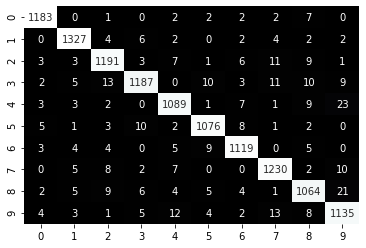

[2021-08-11 10:41:17.353 ip-172-16-187-199:26219 INFO trial.py:198] Training has ended, will refresh one final time in 1 sec.
[2021-08-11 10:41:18.371 ip-172-16-187-199:26219 INFO trial.py:210] Loaded all steps


In [11]:
plot_and_update_confusion_for_all_steps(trial)